# Cox-PH and DeepSurv and possible extensions

This is adapted from a Jupyter Notebook for `DeepSurv` (CoxPH) continuous-time models at [`pycox`](https://github.com/havakv/pycox#continuous-time-models). It informs possible extensions for analyses at the end.

In this notebook we will train the [Cox-PH method](http://jmlr.org/papers/volume20/18-424/18-424.pdf), also known as [DeepSurv](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1).
We will use the METABRIC data sets as an example

A more detailed introduction to the `pycox` package can be found in [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb) about the `LogisticHazard` method.

The main benefit Cox-CC (and the other Cox methods) has over Logistic-Hazard is that it is a continuous-time method, meaning we do not need to discretize the time scale.

In [18]:
# Added 2022Jun12 by yadevinit
# !pip install numpy
# !pip install matplotlib
# !pip install sklearn
# refer https://stackoverflow.com/questions/9956741/how-to-install-multiple-python-packages-at-once-using-pip.
# !pip install numpy matplotlib sklearn

In [19]:
## Uncomment to install `sklearn-pandas`
# ! pip install sklearn-pandas

In [20]:
# Added 2022Jun12 by yadevinit
# !pip install torch
# !pip install torchtuples
# !pip install pycox
# !pip install torch torchtuples pycox

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [22]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

We load the METABRIC data set and split in train, test and validation.

In [23]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [24]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


## Feature transforms
We have 9 covariates, in addition to the durations and event indicators.

We will standardize the 5 numerical covariates, and leave the binary variables as is. As variables needs to be of type `'float32'`, as this is required by pytorch.

In [25]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [26]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

We need no label transforms

In [27]:
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

## Neural net

We create a simple MLP with two hidden layers, ReLU activations, batch norm and dropout. 
Here, we just use the `torchtuples.practical.MLPVanilla` net to do this.

Note that we set `out_features` to 1, and that we have not `output_bias`.

In [28]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

## Training the model

To train the model we need to define an optimizer. You can choose any `torch.optim` optimizer, but here we instead use one from `tt.optim` as it has some added functionality.
We use the `Adam` optimizer, but instead of choosing a learning rate, we will use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate with `model.lr_finder`. See [this post](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for an explanation.

In [29]:
model = CoxPH(net, tt.optim.Adam)

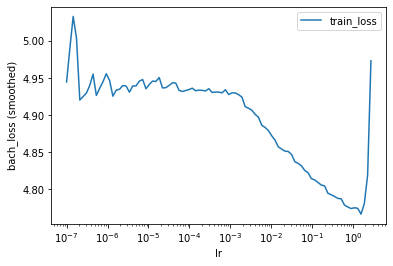

In [30]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [31]:
lrfinder.get_best_lr()

0.15556761439304817

Often, this learning rate is a little high, so we instead set it manually to 0.01

In [32]:
model.optimizer.set_lr(0.01)

We include the `EarlyStopping` callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [33]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [34]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 4.7820,	val_loss: 3.9357
1:	[0s / 0s],		train_loss: 4.6994,	val_loss: 3.9193
2:	[0s / 0s],		train_loss: 4.6338,	val_loss: 3.9362
3:	[0s / 0s],		train_loss: 4.6111,	val_loss: 3.9277
4:	[0s / 0s],		train_loss: 4.5987,	val_loss: 3.9097
5:	[0s / 0s],		train_loss: 4.5905,	val_loss: 3.9115
6:	[0s / 0s],		train_loss: 4.5755,	val_loss: 3.9127
7:	[0s / 0s],		train_loss: 4.5634,	val_loss: 3.9305
8:	[0s / 0s],		train_loss: 4.5575,	val_loss: 3.9196
9:	[0s / 0s],		train_loss: 4.5748,	val_loss: 3.9120
10:	[0s / 0s],		train_loss: 4.5637,	val_loss: 3.9223
11:	[0s / 0s],		train_loss: 4.5609,	val_loss: 3.9467
12:	[0s / 0s],		train_loss: 4.5612,	val_loss: 3.9678
13:	[0s / 0s],		train_loss: 4.5525,	val_loss: 3.9652
14:	[0s / 0s],		train_loss: 4.5518,	val_loss: 3.9631
CPU times: total: 1.12 s
Wall time: 726 ms


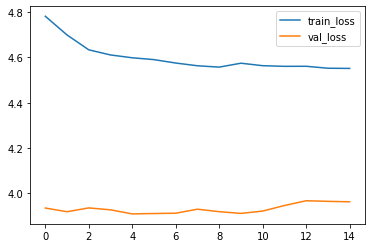

In [35]:
_ = log.plot()

We can get the partial log-likelihood

In [36]:
model.partial_log_likelihood(*val).mean()

-4.9723516

## Prediction

For evaluation we first need to obtain survival estimates for the test set.
This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

However, as `CoxPH` is semi-parametric, we first need to get the non-parametric baseline hazard estimates with `compute_baseline_hazards`. 

Note that for large datasets the `sample` argument can be used to estimate the baseline hazard on a subset.

In [37]:
_ = model.compute_baseline_hazards()

In [38]:
surv = model.predict_surv_df(x_test)

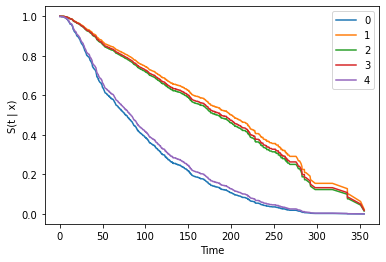

In [39]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

## Evaluation

We can use the `EvalSurv` class for evaluation the concordance, brier score and binomial log-likelihood. Setting `censor_surv='km'` means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [40]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [41]:
ev.concordance_td()

0.6539455839972876

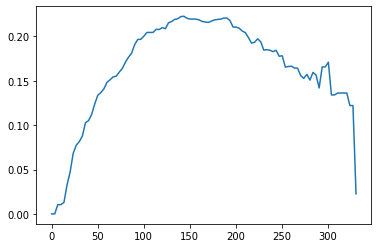

In [42]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [43]:
ev.integrated_brier_score(time_grid)

0.1651507224655492

In [44]:
ev.integrated_nbll(time_grid)

0.48826419843321794

In [ ]:
### Added by yadevinit 2022Jun12:
# http://arxiv.org/abs/1606.00931 "DeepSurv: Personalized Treatment Recommender System Using A
# Cox Proportional Hazards Deep Neural Network" said:
# "... and The Molecular Taxonomy of Breast Cancer International Consortium (METABRIC).
# Because previous research shows that neural networks do not outperform the CPH, our goal is to
# demonstrate that DeepSurv does indeed have state-of-the-art predictive ability in practice on real survival
# datasets..."

In [ ]:
### Extension possibility #1:
# Refer https://autonlab.github.io/auton-survival/ and its White Paper link
# https://www.cs.cmu.edu/~chiragn/papers/auton_survival.pdf
# "auton-survival: an Open-Source Package for Regression, Counterfactual Estimation, Evaluation and Phenotyping
# with Censored Time-to-Event Data" (2022Apr). It includes Deep Survival Machines and DeepSurv and compares
# with Python survival-analyses pipeline/workflow packages such as `lifelines` and `pycox`.

In [ ]:
### Extension possibility #2:
# Refer http://proceedings.mlr.press/v119/yamada20a/yamada20a-supp.pdf
# "Feature Selection using Stochastic Gates- Supplementary Material" (2020Aug). Under heading Reproducibility,
# it gives Details of Cox Proportional Hazard Model. It supplements
# http://proceedings.mlr.press/v119/yamada20a/yamada20a.pdf "Feature Selection using Stochastic Gates".
# https://github.com/runopti/stg/tree/master/python is referred to by https://github.com/jaredleekatzman/DeepSurv
# "... For an updated implementation of the Cox loss function in PyTorch ...".